In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math 
from scipy import stats
from scipy.optimize import curve_fit
from pylab import *
from scipy import special
import seaborn.boxplot

In [774]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [754]:
def qval(pvals, pi0):
    #pvals_sorted = np.sort(pvals)
    #pvals_sorted = pvals_sorted[~np.isnan(pvals_sorted)]

    n = len(pvals)
    q_vals = []
    for i,val in enumerate(pvals):
        q_vals.append((pi0*val*n)/(i+1))
        
    q_vals = np.array(q_vals)
    return q_vals

In [5]:
def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [6]:
def get_mock_runs(exp_df, mock_df, reps):
    exp_runs = [] 
    for i in exp_df:
        exp_runs.append(i.split(' ')[1])
    mock_runs = []
    mock_col = [x for x in list(mock_df.columns)]
    for i in exp_runs:
        for j in mock_col:
            if i == j.split(' ')[1]:
                mock_runs.append(j)
    elements = sorted(set(mock_runs), key=mock_runs.index)
    
    if reps ==1:
        new_mock_df = mock_df[elements]
    elif reps ==0:
        new_mock_df = mock_df[mock_runs]
    return new_mock_df 

In [7]:
def calc_pvals(data, params):
    # calculate the standard deviation of the data
    rpec_std = np.std(data)
    # calculate the distance of the data from the average of the background
    numerator = np.abs(data-params.loc['mu1']['params'])
    # calculate the sum of the standard deviations
    denominator = np.sqrt(2* (rpec_std**2 + params.loc['sigma1']['params']**2 + params.loc['sigma2']['params']**2) )
    
    #calculate the z scores
    z = numerator/denominator
    
    #calculate the p values
    pvals = special.erfc(z)
    #pvals = stats.norm.sf(z)
    
    return pvals

### bring in raw abundance data

In [976]:
data = pd.read_excel('./CFTR-interactome-data_merged_20210524.xlsx', skiprows=2)

In [977]:
# drop runs 7 and 9 
keep_run = []
for i in data:
    if 'Run 7' not in i and 'Run 9' not in i:# and 'Run 8' not in i:
        keep_run.append(i)
    

In [978]:
data2 = data[keep_run]

In [980]:
data2.head(50)

,Gene Name,Accesion Number,Description,Run 1 TD-tomato,Run 1 WT-DMSO,Run 1 WT-VX809,Run 1 P67L-DMSO-1,Run 1 P67L-VX809-1,Run 1 F508del-DMSO-1,Run 1 F508del-VX809-1,Run 1 P67L-DMSO-2,Run 1 P67L-VX809-2,Run 1 F508del-DMSO-2,Run 1 F508del-VX809-2,Run 2 TD-tomato,Run 2 WT-DMSO,Run 2 WT-VX809,Run 2 P67L-DMSO-1,Run 2 P67L-VX809-1,Run 2 F508del-DMSO-1,Run 2 F508del-VX809-1,Run 2 P67L-DMSO-2,Run 2 P67L-VX809-2,Run 2 F508del-DMSO-2,Run 2 F508del-VX809-2,Run 3 TD-tomato,Run 3 WT-DMSO,Run 3 WT-VX809,Run 3 P67L-DMSO-1,Run 3 P67L-VX809-1,Run 3 F508del-DMSO-1,Run 3 F508del-VX809-1,Run 3 P67L-DMSO-2,Run 3 P67L-VX809-2,Run 3 F508del-DMSO-2,Run 3 F508del-VX809-2,Run 4 TD-tomato,Run 4 WT-DMSO,Run 4 WT-VX809,Run 4 P67L-DMSO-1,Run 4 P67L-VX809-1,Run 4 F508del-DMSO-1,Run 4 F508del-VX809-1,Run 4 P67L-DMSO-2,Run 4 P67L-VX809-2,Run 4 F508del-DMSO-2,Run 4 F508del-VX809-2,Run 5 TD-tomato,Run 5 WT-DMSO,Run 5 WT-VX809,Run 5 P67L-DMSO,Run 5 P67L-VX809,Run 5 F508del-DMSO,Run 5 F508del-VX809,Run 5 L206W-DMSO,Run 5 L206W-VX809,Run 5 G85E-DMSO,Run 5 G85E-VX809,Run 6 td-tomato,Run 6 WT-DMSO,Run 6 P67L-DMSO,Run 6 P67L-VX809,Run 6 P67L-VX661,Run 6 P67L-VX445,Run 6 P67L-VX661-VX445,Run 6 L206W-DMSO,Run 6 L206W-VX809,Run 6 L206W-VX661,Run 6 L206W-VX445,Run 8 td-tomato,Run 8 WT-DMSO,Run 8 P67L-DMSO,Run 8 P67L-VX809,Run 8 P67L-VX445,Run 8 td-tomato.1,Run 8 WT-DMSO.1,Run 8 P67L-DMSO-37C,Run 8 P67L-VX809-37C,Run 8 P67L-DMSO-28C,Run 8 P67L-VX809-28C,Run 10 TD-tomato,Run 10 WT-DMSO,Run 10 WT-VX809,Run 10 P67L-DMSO,Run 10 P67L-VX809,Run 10 F508del-DMSO,Run 10 F508del-VX809,Run 10 L206W-DMSO,Run 10 L206W-VX809,Run 10 G85E-DMSO,Run 10 G85E-VX809,Run 11 L206W-VX809,Run 11 F508del-DMSO,Run 11 F508del-VX809,Run 11 TD-tomato,Run 11 WT-DMSO,Run 11 WT-VX809,Run 11 P67L-DMSO,Run 11 P67L-VX809,Run 11 G85E-DMSO,Run 11 G85E-VX809,Run 11 L206W-DMSO
0,NaN,P04207,Ig kappa chain V-III region CLL OS=Homo sapien...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.0,127.1,78.4,133.9,84.8,89.2,78.9,124.8,55.6,80.2,159.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.1,302.2,327.8,496.2,395.7,853.3,349.4,447.7,597.3,1015.9,1022.8,77.9,86.2,57.5,157.4,504.5,92.0,56.6,144.5,74.1,37.2,94.7,1836.5,1734.3,717.8,2067.2,2233.7,1791.1,1585.1,2120.0,2196.4,2130.4,1789.8,5.145206e+05,1.474223e+06,3.970529e+05,2.778893e+06,1.601748e+06,3.250570e+06,1.592087e+06,7.980012e+05,5.498788e+05,2.056198e+06,3.367287e+06,134.4,133.6,191.9,170.2,930.1,304.9,359.5,462.2,264.4,474.0,407.1,20.4,23.3,33.3,99.6,81.9,106.6,41.3,35.7,21.0,44.9,13.4
1,HSPA2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.3,677.6,310.1,980.3,865.0,716.2,799.2,1029.2,1027.4,963.8,724.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.8,6.8,6.1,23.9,24.1,14.4,13.1,10.0,7.0,6.3,4.0
2,AGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AGK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.6,256.0,279.0,674.2,299.3,659.4,433.2,506.6,507.3,1539.2,1237.4,67.8,53.0,33.8,42.3,114.1,56.2,28.3,46.7,75.0,16.0,75.7,178.0,260.8,97.5,352.3,322.9,250.4,390.2,279.9,347.4,320.5,236.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.2,62.3,107.0,70.8,357.9,101.8,101.7,175.7,117.7,207.3,204.1,220.2,144.1,189.1,864.2,797.9,627.3,475.7,467.9,173.1,256.7,124.8
4,HSPA6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [981]:
run_meds = {'Run 1': [], 'Run 2': [], 'Run 3': [], 'Run 4': [],
            'Run 5': [], 'Run 6': [], 'Run 8': [],
            'Run 9': [], 'Run 10': [], 'Run 11': []}

for i in data2:
    if 'Run 1 ' in i:
        run_meds['Run 1'].append(data2[i].median())
    if 'Run 2 ' in i:
        run_meds['Run 2'].append(data2[i].median())
    if 'Run 3 ' in i:
        run_meds['Run 3'].append(data2[i].median())
    if 'Run 4 ' in i:
        run_meds['Run 4'].append(data2[i].median())
    if 'Run 5 ' in i:
        run_meds['Run 5'].append(data2[i].median())
    if 'Run 6 ' in i:
        run_meds['Run 6'].append(data2[i].median())
    if 'Run 8 ' in i:
        run_meds['Run 8'].append(data2[i].median())
    if 'Run 9 ' in i:
        run_meds['Run 9'].append(data2[i].median())
    if 'Run 10 ' in i:
        run_meds['Run 10'].append(data2[i].median())
    if 'Run 11 ' in i:
        run_meds['Run 11'].append(data2[i].median())

In [982]:
data3 = pd.DataFrame()
data3['Gene Name'] = data2['Gene Name']
for i in data2:
    if 'Run' in i:
        run = ' '.join(i.split(' ')[0:2])
        norm = np.mean(run_meds[run])/ data2[i].median()
        data3[i] = data2[i]*norm

### define conditions of interest 

In [983]:
WT_DMSO = []
WT_VX809 = []
F508del_DMSO = []
F508del_VX809 = []
P67L_DMSO = []
P67L_VX809 = [] 
L206W_DMSO = []
L206W_VX809 = [] 
G85E_DMSO = []
G85E_VX809 = [] 
mock = []
for i in data3:
    if "WT-DMSO" in i:
        WT_DMSO.append(i)
    if "WT-VX809" in i:
        WT_VX809.append(i)
    if "F508del-DMSO" in i:
        F508del_DMSO.append(i)
    if "F508del-VX809" in i:
        F508del_VX809.append(i)
    if 'td-tomato' in i or 'TD-tomato' in i:
        mock.append(i)
    if "P67L-DMSO" in i:
        P67L_DMSO.append(i)
    if "P67L-VX809" in i:
        P67L_VX809.append(i)
    if "L206W-DMSO" in i:
        L206W_DMSO.append(i)
    if "L206W-VX809" in i:
        L206W_VX809.append(i)
    if "G85E-DMSO" in i:
        G85E_DMSO.append(i)
    if "G85E-VX809" in i:
        G85E_VX809.append(i)

In [984]:
TD_tom = np.log2(data2[mock])

# WT + DMSO Analysis

In [985]:
TD_tom = np.log2(data3[mock])

In [986]:
WT_CFTR_DMSO = np.log2(data3[WT_DMSO])

In [987]:
WT_DMSO_mocks = get_mock_runs(WT_CFTR_DMSO, TD_tom,1)
WT_DMSO_over_TD = pd.DataFrame(WT_CFTR_DMSO.values - WT_DMSO_mocks.values)

In [778]:
stat_vals_WT_DMSO = stats.ttest_rel(WT_CFTR_DMSO.values, WT_DMSO_mocks.values, axis=1, nan_policy= 'omit', alternative='two-sided')

In [878]:
## filter out any proteins which were not identified in at least 3 runs 
WT_DMSO_over_TD_2plot = pd.DataFrame()
WT_DMSO_over_TD_2plot['nans'] = WT_DMSO_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(WT_DMSO_over_TD_2plot['nans']):
    if val >7:
        drop_rows.append(i)
        
WT_DMSO_over_TD = WT_DMSO_over_TD.drop(axis=0, index=drop_rows)

print('the number of interactors left = ' +str(len(WT_DMSO_over_TD)))

the number of interactors left = 2788


In [782]:
len(np.delete(np.array(stat_vals_WT_DMSO[1]), drop_rows))

1607

In [879]:
WT_DMSO_over_TD_2plot = pd.DataFrame()
WT_DMSO_over_TD_2plot['avg'] = WT_DMSO_over_TD.mean(axis=1)
WT_DMSO_over_TD_2plot['med'] = WT_DMSO_over_TD.median(axis=1)
WT_DMSO_over_TD_2plot['std'] = WT_DMSO_over_TD.std(axis=1)
WT_DMSO_over_TD_2plot['sum'] = WT_DMSO_over_TD.sum(axis=1)
WT_DMSO_over_TD_2plot['sum'] = WT_DMSO_over_TD_2plot['sum'].replace(0.0, np.nan)
WT_DMSO_over_TD_2plot['pvals'] = np.delete(np.array(stat_vals_WT_DMSO[1]), drop_rows)
WT_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(WT_DMSO_over_TD_2plot['pvals'])
WT_DMSO_over_TD_2plot['-log10 p_val'] = WT_DMSO_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of standard deviation log2(FC)')

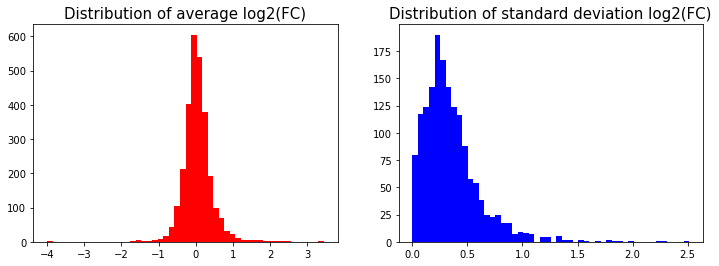

In [730]:
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(WT_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(WT_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

              params         sigma
mu1     2.251701e-02  1.000174e-02
sigma1 -4.549963e-01  1.004624e-02
A1      4.183640e+02  7.972283e+00
mu2     5.553270e+03  3.439848e+13
sigma2 -4.574157e+02  4.162948e+12
A2     -1.962061e+06  6.903015e+14


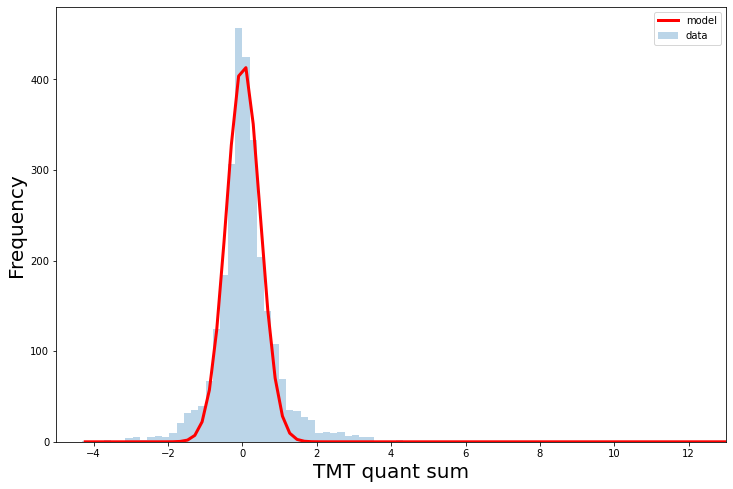

In [733]:
data=WT_DMSO_over_TD_2plot['sum']
plt.figure(figsize=(12,8))
y,x,_=hist(data,100,alpha=.3,label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#expected=(0,1,200,
 #         1,0.02,-76)

expected=(0,2,100,
          2,0.02,6)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.xlim(-5,13)
plt.xlabel('TMT quant sum', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
legend()
WT_parameters = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:]) 
print(WT_parameters)

WT_DMSO_over_TD_2plot['pvals'] = calc_pvals(data, WT_parameters)

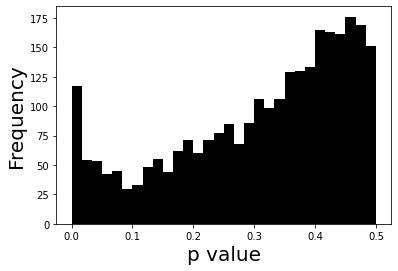

In [881]:
## plot a histogram of the p values 
#plt.hist(WT_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.hist(WT_DMSO_over_TD_2plot['pvals_sum'], bins=30, color='k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()

In [880]:
mu = WT_DMSO_over_TD_2plot['sum'].mean()
std = WT_DMSO_over_TD_2plot['sum'].std()
z = (WT_DMSO_over_TD_2plot['sum']-mu)/std

WT_DMSO_over_TD_2plot['pvals_sum'] = scipy.stats.norm.sf(abs(z))

In [803]:
# calculat the log 10 FDR 
# rank order the p values 
WT_DMSO_over_TD_2plot = WT_DMSO_over_TD_2plot.sort_values('pvals')
#calculate pi i 
lamda = 0.5
N = len(WT_DMSO_over_TD_2plot)
for i,val in enumerate(WT_DMSO_over_TD_2plot['pvals']):
    if val >= (lamda - 0.05):
        cutoff = i+1
        print('The cutoff rank is: ' + str(i+1))
        break
        
pi0 = (N-cutoff)/(N-(1-lamda))
print(pi0)
WT_DMSO_over_TD_2plot['-log10(qvals)'] = -np.log10(qval(WT_DMSO_over_TD_2plot['pvals'],pi0))

The cutoff rank is: 828
0.48490507314036724


In [995]:
corr_p = []
WT_DMSO_over_TD_2plot = WT_DMSO_over_TD_2plot.sort_values('pvals')
N= len(WT_DMSO_over_TD_2plot['pvals'])
for i,val in enumerate(WT_DMSO_over_TD_2plot['pvals']):
    corr_p.append(((i+1)/N)*0.10)


WT_DMSO_over_TD_2plot['BH-corr-pvals'] = corr_p

In [996]:
WT_DMSO_over_TD_2plot

,avg,med,std,sum,pvals,-log10 p_val,pvals_sum,BH-corr-pvals
1589,0.199730,0.199730,0.000044,0.399459,0.000099,4.003260,3.672783e-01,0.000036
329,0.645451,0.652477,0.012354,1.936352,0.000122,3.913342,1.972275e-02,0.000072
2329,1.913947,2.127408,0.741036,15.311576,0.000162,3.790412,2.373978e-65,0.000108
2017,-0.205165,-0.205165,0.000096,-0.410329,0.000211,3.674931,2.852116e-01,0.000143
413,-0.297101,-0.288434,0.027858,-1.188405,0.000225,3.646923,7.515649e-02,0.000179
1197,0.434686,0.471502,0.180160,3.042804,0.000695,3.157955,4.867065e-04,0.000215
231,0.460437,0.470250,0.077276,1.841749,0.001271,2.895896,2.537385e-02,0.000251
2616,0.052827,0.052827,0.000261,0.105654,0.002227,2.652185,4.959401e-01,0.000287
2326,-0.473985,-0.484637,0.046515,-1.421956,0.003195,2.495551,4.457766e-02,0.000323
1615,1.013897,1.037383,0.107110,3.041692,0.003699,2.431864,4.888691e-04,0.000359


In [792]:
sum(np.isnan(WT_DMSO_over_TD_2plot['pvals']))

0

Text(0, 0.5, '-log10(p val)')

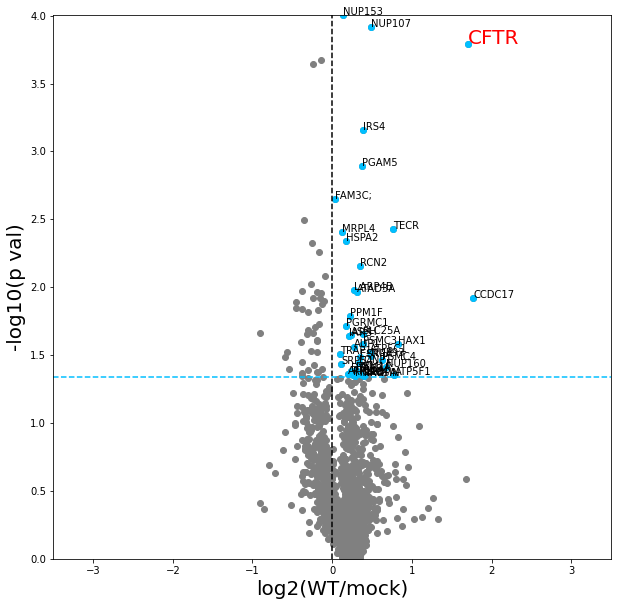

In [829]:
x = WT_DMSO_over_TD_2plot['avg']

y = -np.log10(WT_DMSO_over_TD_2plot['pvals'])
#y = WT_DMSO_over_TD_2plot['-log10(qvals)']
#y = -np.log10(WT_DMSO_over_TD_2plot['BH-corr-pvals'])
c =0.4
x = x.replace(np.inf, np.nan)
y = y.replace(np.inf, np.nan)

cutoff = -np.log10(0.046)
rng = 3.5
fontsize = 20
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'grey')

plt.vlines((0), 0, max(y), ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))
'''
#plot medium confidence cut off curve
x_std = np.std(x)
x_rng = np.arange(x_std, rng, 0.01)
y_rng = c/(x_rng-x_std)
plt.plot(x_rng,y_rng, color='deepskyblue',ls='--' )
'''

for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue')
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize, color ='r')
        else: 
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-10)
            

plt.xlabel('log2(WT/mock)', size=fontsize)
plt.ylabel('-log10(p val)', size=fontsize)

# WT + VX-809 Analysis

In [904]:
TD_tom = np.log2(data2[mock])

In [905]:
WT_CFTR_VX809 = np.log2(data2[WT_VX809])

In [906]:
WT_VX809_mocks = get_mock_runs(WT_CFTR_VX809, TD_tom, 1)
WT_VX809_over_TD = pd.DataFrame(WT_CFTR_VX809.values - WT_VX809_mocks.values)

In [907]:
len(WT_VX809_over_TD)

3323

In [908]:
stat_vals_WT_VX809 = stats.ttest_rel(WT_CFTR_VX809.values,  WT_VX809_mocks.values, axis=1, nan_policy= 'omit', alternative='two-sided')

In [909]:
## filter out any proteins which were not identified in at least 3 runs 
WT_VX809_over_TD_2plot = pd.DataFrame()
WT_VX809_over_TD_2plot['nans'] = WT_VX809_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(WT_VX809_over_TD_2plot['nans']):
    if val >6:
        drop_rows.append(i)
        
WT_VX809_over_TD = WT_VX809_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' + str(len(WT_VX809_over_TD)))

the number of interactors left = 2313


In [910]:
WT_VX809_over_TD_2plot = pd.DataFrame()
WT_VX809_over_TD_2plot['avg'] = WT_VX809_over_TD.mean(axis=1)
WT_VX809_over_TD_2plot['med'] = WT_VX809_over_TD.median(axis=1)
WT_VX809_over_TD_2plot['std'] = WT_VX809_over_TD.std(axis=1)
WT_VX809_over_TD_2plot['sum'] = WT_VX809_over_TD.sum(axis=1)
WT_VX809_over_TD_2plot['sum'] = WT_VX809_over_TD_2plot['sum'].replace(0.0, np.nan)
WT_VX809_over_TD_2plot['pvals'] = np.delete(np.array(stat_vals_WT_VX809[1]), drop_rows)
WT_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(WT_VX809_over_TD_2plot['pvals'])
WT_VX809_over_TD_2plot['-log10 p_val'] = WT_VX809_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of standard deviation log2(FC)')

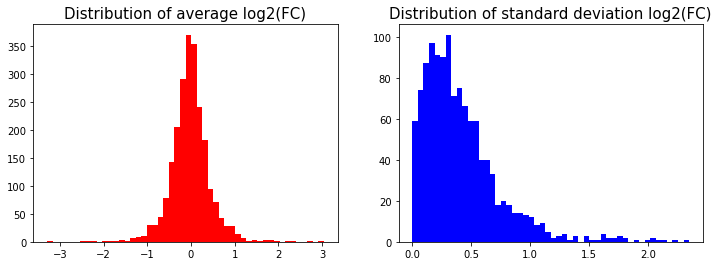

In [853]:
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(WT_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(WT_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

            params      sigma
mu1      -0.010985   0.007264
sigma1    0.293975   0.011955
A1      224.819609  10.430738
mu2      -0.131730   0.022145
sigma2   -0.801476   0.032372
A2      132.516371  10.680478


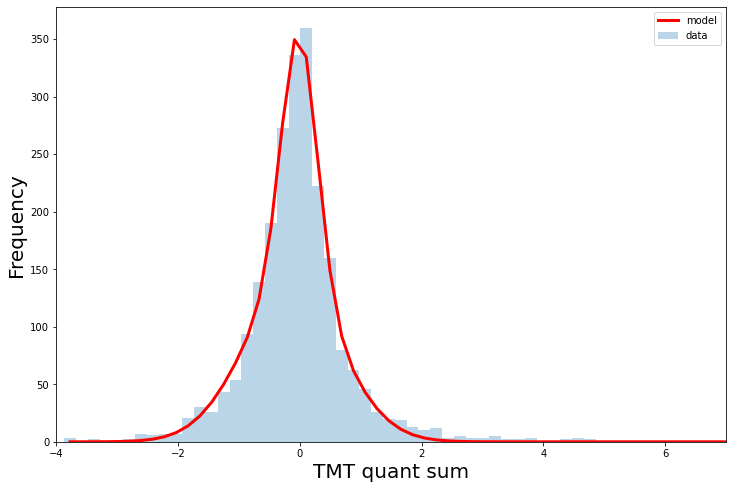

In [887]:
data=WT_VX809_over_TD_2plot['sum']
plt.figure(figsize=(12,8))
y,x,_=hist(data,100,alpha=.3,label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-1, .47, 40,
          1.2, .05, 26)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.xlim(-4,7)
plt.xlabel('TMT quant sum', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
legend()
WT_parameters = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:]) 
print(WT_parameters)

WT_VX809_over_TD_2plot['pvals'] = calc_pvals(data, WT_parameters)

In [911]:
mu = WT_VX809_over_TD_2plot['sum'].mean()
std = WT_VX809_over_TD_2plot['sum'].std()
z = (WT_VX809_over_TD_2plot['sum']-mu)/std

WT_VX809_over_TD_2plot['pvals_sum'] = scipy.stats.norm.sf(abs(z))

/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2007: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


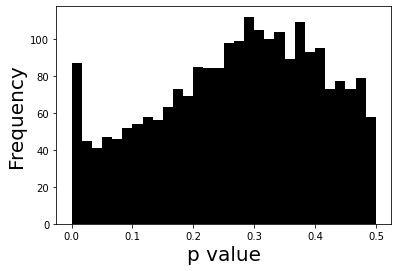

In [912]:
## plot a histogram of the p values 
plt.hist(WT_VX809_over_TD_2plot['pvals_sum'], bins=30, color = 'k')
#plt.hist(stat_vals_WT_VX809[1], bins=30, color='k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()

In [184]:
# calculat the log 10 FDR 

# rank order the p values 
WT_VX809_over_TD_2plot = WT_VX809_over_TD_2plot.sort_values('pvals')


#calculate pi i 
lamda = 0.4
N = len(WT_VX809_over_TD_2plot )
for i,val in enumerate(WT_VX809_over_TD_2plot['pvals']):
    if val >= (lamda - 0.05):
        cutoff = i+1
        break
        
pi0 = (N-cutoff)/(N-(1-lamda))
WT_VX809_over_TD_2plot['-log10(qvals)'] = -np.log10(qval(WT_VX809_over_TD_2plot['pvals'],pi0))

Text(0, 0.5, 'Log10(FDR)')

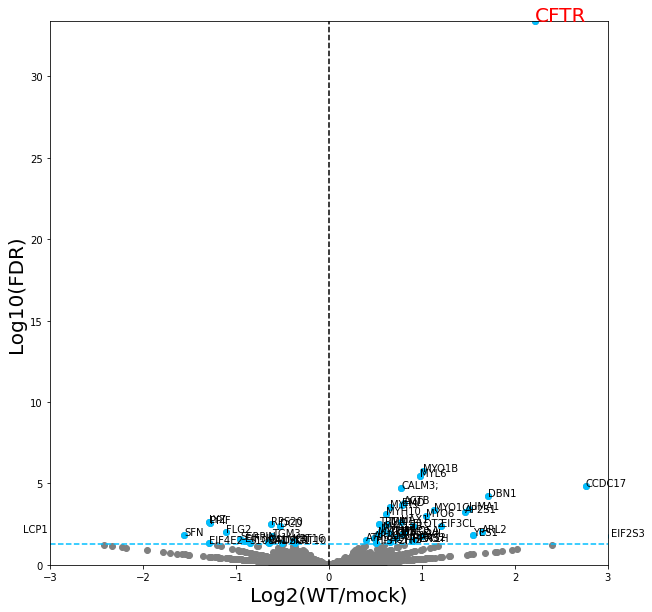

In [481]:
x = WT_VX809_over_TD_2plot['avg']
y = -np.log10(WT_VX809_over_TD_2plot['pvals'])
#y = WT_VX809_over_TD_2plot['-log10(qvals)']

y = y.replace(np.inf, np.nan)

cutoff = -np.log10(0.05)
rng = 3.0
fontsize = 20
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'grey')
plt.vlines((0), 0, np.amax(y)*1.2, ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,np.amax(y))
'''
#plot medium confidence cut off curve
x_std = np.std(x)
x_rng = np.arange(x_std, rng, 0.0001)
y_rng = c/(x_rng-x_std)
plt.plot(x_rng,y_rng, color='deepskyblue',ls='--' )
'''
for i in x.items(): 
    if y[i[0]] >= cutoff: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue')
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize, color ='r')
        else: 
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-10)
            


plt.xlabel('Log2(WT/mock)', size=fontsize)
plt.ylabel('Log10(FDR)', size=fontsize)

# F508del +DMSO Analysis

In [939]:
TD_tom = np.log2(data2[mock])

In [940]:
F508del_CFTR_DMSO = np.log2(data2[F508del_DMSO])

In [941]:
F508del_DMSO_mocks = get_mock_runs(F508del_CFTR_DMSO, TD_tom,0)
F508del_DMSO_over_TD = pd.DataFrame(F508del_CFTR_DMSO.values - F508del_DMSO_mocks.values)

In [942]:
len(F508del_DMSO_over_TD)

3323

In [943]:
F508del_stat_vals_DMSO = stats.ttest_rel(F508del_CFTR_DMSO.values, F508del_DMSO_mocks.values, axis=1, nan_policy= 'omit')

In [944]:
## filter out any proteins which were not identified in at least 3 runs 
F508del_DMSO_over_TD_2plot = pd.DataFrame()
F508del_DMSO_over_TD_2plot['nans'] = F508del_DMSO_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(F508del_DMSO_over_TD_2plot['nans']):
    if val >9:
        drop_rows.append(i)
        
F508del_DMSO_over_TD = F508del_DMSO_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(F508del_DMSO_over_TD)))

the number of interactors left = 1488


In [946]:
## calculate some statistical properties...
F508del_DMSO_over_TD_2plot = pd.DataFrame()
F508del_DMSO_over_TD_2plot['avg'] = F508del_DMSO_over_TD.mean(axis=1)
F508del_DMSO_over_TD_2plot['med'] = F508del_DMSO_over_TD.median(axis=1)
F508del_DMSO_over_TD_2plot['std'] = F508del_DMSO_over_TD.std(axis=1)
F508del_DMSO_over_TD_2plot['sum'] = F508del_DMSO_over_TD.sum(axis=1)
F508del_DMSO_over_TD_2plot['sum'] = F508del_DMSO_over_TD_2plot['sum'].replace(0.0, np.nan)
F508del_DMSO_over_TD_2plot['pvals'] = np.delete(np.array(F508del_stat_vals_DMSO[1]), drop_rows)
F508del_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(F508del_DMSO_over_TD_2plot['pvals'])
F508del_DMSO_over_TD_2plot['-log10 p_val'] = F508del_DMSO_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

Text(0.5, 1.0, 'Distribution of standard deviation log2(FC)')

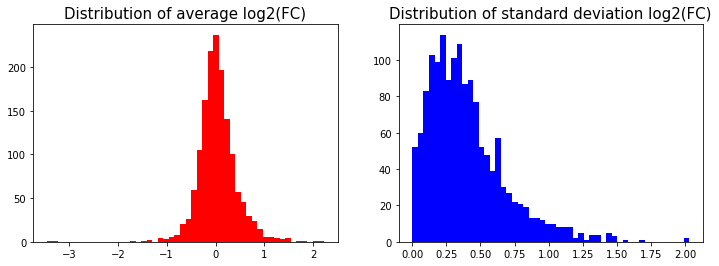

In [528]:
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(F508del_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(F508del_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

            params      sigma
mu1      -0.039533   0.012369
sigma1    0.742466   0.019746
A1      332.526098  11.346699
mu2       0.427364   0.096862
sigma2   -1.800324   0.111346
A2       82.538486  11.666276


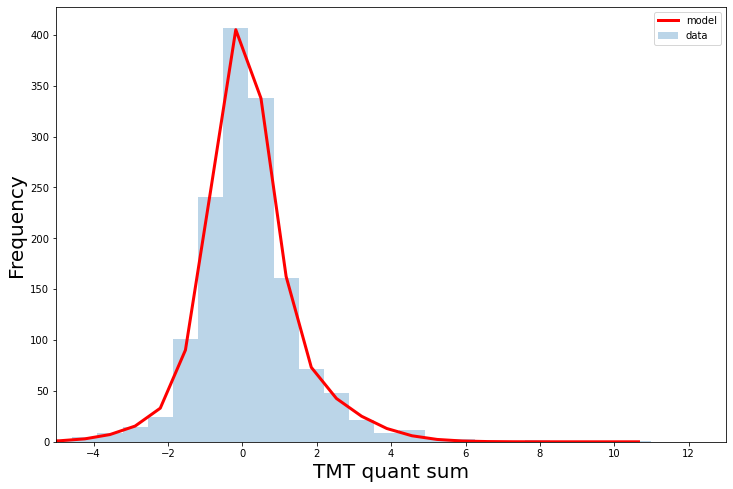

In [935]:
## plot the sum of the log fold two changes as a histogram and fit a bimodal distribution 
data=F508del_DMSO_over_TD_2plot['sum']
plt.figure(figsize=(12,8))
y,x,_=hist(data,30,alpha=.3,label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(0,0.86,25,
          2.25,1, 6)

params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.xlim(-5,13)
plt.xlabel('TMT quant sum', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
legend()

F508del_parameters = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:]) 
print(F508del_parameters)

# calculate the pvalue according to Pankow et al. Nature, 2015
F508del_DMSO_over_TD_2plot['pvals'] = calc_pvals(data, F508del_parameters)

In [949]:
mu = F508del_DMSO_over_TD_2plot['sum'].mean()
std = F508del_DMSO_over_TD_2plot['sum'].std()
z = (F508del_DMSO_over_TD_2plot['sum']-mu)/std

F508del_DMSO_over_TD_2plot['pvals_sum'] = scipy.stats.norm.sf(abs(z))*2

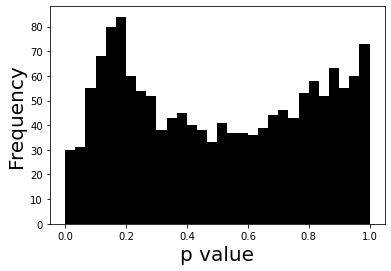

In [950]:
## plot a histogram of the p values 
plt.hist(F508del_DMSO_over_TD_2plot['pvals_sum'], bins=30, color = 'k')
#plt.hist(F508del_stat_vals_DMSO[1], bins=30, color='k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()

In [585]:
# calculat the log 10 FDR 

# rank order the p values 
F508del_DMSO_over_TD_2plot = F508del_DMSO_over_TD_2plot.sort_values('pvals')


#calculate pi i 
lamda = 0.9
N = len(F508del_DMSO_over_TD_2plot )
for i,val in enumerate(F508del_DMSO_over_TD_2plot['pvals']):
    if val >= (lamda - 0.05):
        cutoff = i+1
        break
        
pi0 = (N-cutoff)/(N-(1-lamda))
F508del_DMSO_over_TD_2plot['-log10(qvals)'] = -np.log10(qval(F508del_DMSO_over_TD_2plot['pvals'],pi0))

<ipython-input-585-ae53c58770e4>:16: RuntimeWarning: invalid value encountered in log10
  F508del_DMSO_over_TD_2plot['-log10(qvals)'] = -np.log10(qval(F508del_DMSO_over_TD_2plot['pvals'],pi0))


ZC3H14
AASS
MRPL37
DDI2; 
NUP107
SRSF6
BAG2
RPS6
VDAC2
SRRM1
CCDC17
SEC61A
CANX
EIF3CL
LUC7L
ATP5C1
MRPL12
CTU1
TUBB4B
FAM54A
TFIP11
SF3B2
RLIM
PM20D2
DDX20
EMD
NDUFA9
EFHD1
TMEM11
IPO9
SCNM1;
PLOD2
PSME3
BYSL
ARHGEF
EMC4
HTRA2
ESYT2
SNW1
ACOT9
GPHN
LMNB1
CFTR
HNRNPH
MRPS34
HNRNPU
STOML2
AMOT
FKBP8
RBM14;
PAG1
ARPC3
SYNCRI
TCEB1;
GMPPA
MYO5B
IKBKG
ARPC5L
ACTR3B
PABPC1
POLD1
HAX1
CALM3;


Text(0, 0.5, '-log10(FDR)')

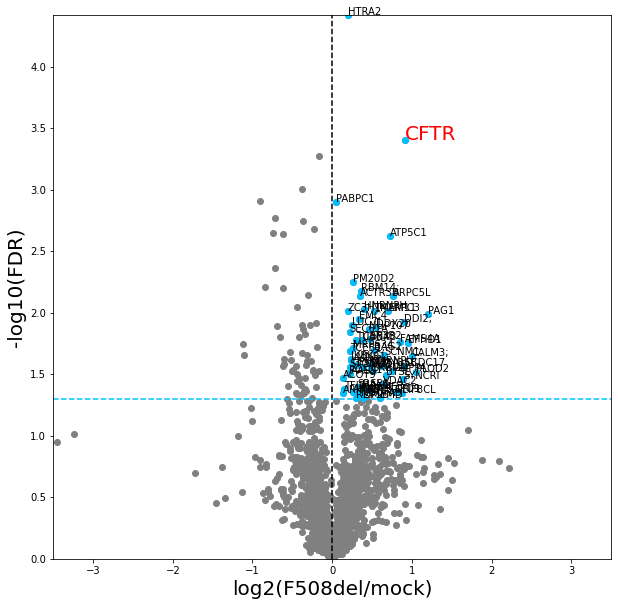

In [593]:
x = F508del_DMSO_over_TD_2plot['avg']
#y = F508del_DMSO_over_TD_2plot['-log10(qvals)']
y = F508del_DMSO_over_TD_2plot['-log10 p_val']
#y = -np.log10(F508del_DMSO_over_TD_2plot['pvals'])

x = x.replace(np.inf, np.nan)
y = y.replace(np.inf, np.nan)
c=0.4
cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 20
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'grey')

plt.vlines((0), 0, max(y), ls='--' , color = 'k')

plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))
'''
#plot medium confidence cut off curve
x_std = np.std(x)
x_rng = np.arange(x_std, rng, 0.01)
y_rng = c/(x_rng-x_std)
plt.plot(x_rng,y_rng, color='deepskyblue',ls='--' )

'''
#for i,val in enumerate(x):
 #   plt.text(x[i],y[i], str(data2.iloc[i]['Gene Name'])[:6], size=fontsize-10)
   
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue')
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize, color ='r')
        else: 
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-10)
        print(str(data2.iloc[i[0]]['Gene Name'])[:6])
plt.xlabel('log2(F508del/mock)', size=fontsize)
plt.ylabel('-log10(FDR)', size=fontsize)

# F508del + VX-809 Analysis

In [967]:
TD_tom = np.log2(data2[mock])

In [968]:
F508del_CFTR_VX809 = np.log2(data2[F508del_VX809])

In [969]:
F508del_VX809_mocks = get_mock_runs(F508del_CFTR_VX809, TD_tom,0)
F508del_VX809_over_TD = pd.DataFrame(F508del_CFTR_VX809.values - F508del_VX809_mocks.values)

In [970]:
len(F508del_VX809_over_TD)

3323

In [971]:
F508del_stat_vals_VX809 = stats.ttest_rel(F508del_CFTR_VX809.values,  F508del_VX809_mocks.values, axis=1, nan_policy= 'omit')

In [972]:
## filter out any proteins which were not identified in at least 3 runs 
F508del_VX809_over_TD_2plot = pd.DataFrame()
F508del_VX809_over_TD_2plot['nans'] = F508del_VX809_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(F508del_VX809_over_TD_2plot['nans']):
    if val >9:
        drop_rows.append(i)
        
F508del_VX809_over_TD = F508del_VX809_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(F508del_VX809_over_TD)))

the number of interactors left = 1487


In [973]:
F508del_VX809_over_TD_2plot = pd.DataFrame()
F508del_VX809_over_TD_2plot['avg'] = F508del_VX809_over_TD.mean(axis=1)
F508del_VX809_over_TD_2plot['std'] = F508del_VX809_over_TD.std(axis=1)
F508del_VX809_over_TD_2plot['med'] = F508del_VX809_over_TD.median(axis=1)
F508del_VX809_over_TD_2plot['sum'] = F508del_VX809_over_TD.sum(axis=1)
F508del_VX809_over_TD_2plot['sum'] = F508del_VX809_over_TD_2plot['sum'].replace(0.0, np.nan)
F508del_VX809_over_TD_2plot['pvals'] = np.delete(F508del_stat_vals_VX809[1], drop_rows)
F508del_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(F508del_VX809_over_TD_2plot['pvals'])
F508del_VX809_over_TD_2plot['-log10 p_val'] = F508del_VX809_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

Text(0.5, 1.0, 'Distribution of standard deviation log2(FC)')

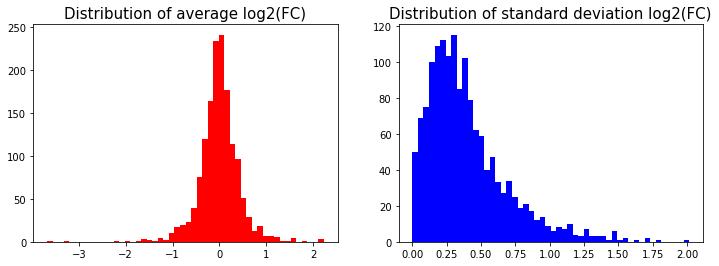

In [536]:
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(F508del_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(F508del_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

            params         sigma
mu1       0.432085  1.300466e-01
sigma1    2.042527  1.093894e-01
A1      266.225053  6.254001e+00
mu2      -2.728295  1.517396e+03
sigma2    0.261621  7.743212e+03
A2      456.088326  5.213957e+07


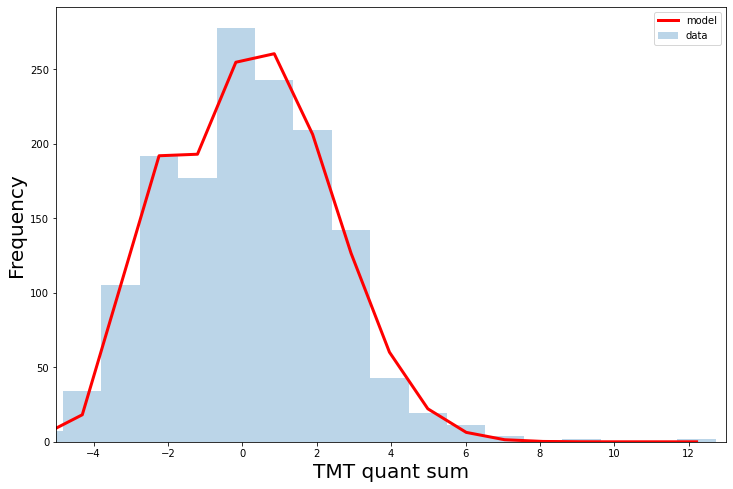

In [990]:
## plot the sum of the log fold two changes as a histogram and fit a bimodal distribution 
data=F508del_VX809_over_TD_2plot['sum']
plt.figure(figsize=(12,8))
y,x,_=hist(data,30,alpha=.3,label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(0,0.86,25,
          2.25,1, 6)

params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.xlim(-5,13)
plt.xlabel('TMT quant sum', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
legend()

F508del_parameters = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:]) 
print(F508del_parameters)

# calculate the pvalue according to Pankow et al. Nature, 2015
F508del_VX809_over_TD_2plot['pvals'] = calc_pvals(data, F508del_parameters)

In [974]:
mu = F508del_VX809_over_TD_2plot['sum'].mean()
std = F508del_VX809_over_TD_2plot['sum'].std()
z = (F508del_VX809_over_TD_2plot['sum']-mu)/std

F508del_VX809_over_TD_2plot['pvals_sum'] = scipy.stats.norm.sf(abs(z))

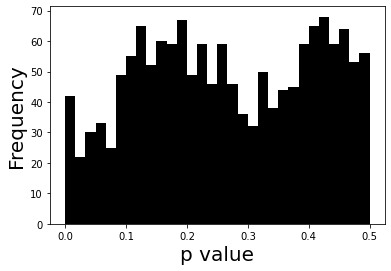

In [975]:
## plot a histogram of the p values 
plt.hist(F508del_VX809_over_TD_2plot['pvals_sum'], bins=30, color = 'k')
#plt.hist(F508del_stat_vals_VX809[1], bins=30, color='k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()

In [110]:
# calculat the log 10 FDR 

# rank order the p values 
F508del_VX809_over_TD_2plot = F508del_VX809_over_TD_2plot.sort_values('pvals')


#calculate pi i 
lamda = 0.4
N = len(F508del_VX809_over_TD_2plot )
for i,val in enumerate(F508del_VX809_over_TD_2plot['pvals']):
    if val >= (lamda - 0.05):
        cutoff = i+1
        break
        
pi0 = (N-cutoff)/(N-(1-lamda))
F508del_VX809_over_TD_2plot['-log10(qvals)'] = -np.log10(qval(F508del_VX809_over_TD_2plot['pvals'],pi0))

Text(0, 0.5, '-log10(FDR)')

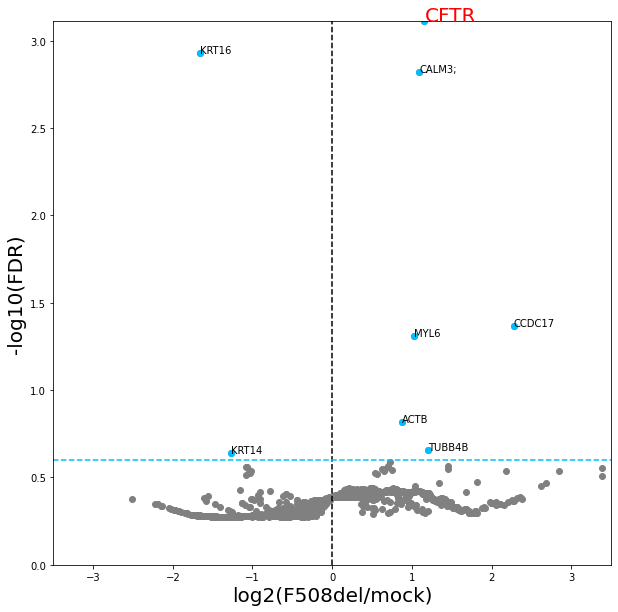

In [117]:
x = F508del_VX809_over_TD_2plot['avg']
#y = -np.log10(F508del_VX809_over_TD_2plot['pvals'])

y = F508del_VX809_over_TD_2plot['-log10(qvals)']
x = x.replace(np.inf, np.nan)
y = y.replace(np.inf, np.nan)
c = 0.4
cutoff = -np.log10(0.25)
rng = 3.5
fontsize = 20
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'grey')

plt.vlines((0), 0, max(y), ls='--' , color = 'k')

plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))
'''
#plot medium confidence cut off curve
x_std = np.std(x)
x_rng = np.arange(x_std, rng, 0.01)
y_rng = c/(x_rng-x_std)
plt.plot(x_rng,y_rng, color='deepskyblue',ls='--' )
'''
#for i,val in enumerate(x):
 #   plt.text(x[i],y[i], str(data2.iloc[i]['Gene Name'])[:6], size=fontsize-10)
    
    
for i in x.items(): 
    if  y[i[0]] >= cutoff: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std:
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue')
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize, color ='r')
        else: 
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-10)

plt.xlabel('log2(F508del/mock)', size=fontsize)
plt.ylabel('-log10(FDR)', size=fontsize)

# P67L + DSMO Analysis

In [539]:
TD_tom = np.log2(data3[mock])

In [540]:
## avgerage TD tomato controls in run 8
TD_tom['Run 8 td-tomato'] = (TD_tom['Run 8 td-tomato']+TD_tom['Run 8 td-tomato.1'])/2
TD_tom = TD_tom.drop(['Run 8 td-tomato.1'], axis=1)

In [548]:
P67L_CFTR_DMSO = np.log2(data3[P67L_DMSO])

In [549]:
P67L_CFTR_DMSO = P67L_CFTR_DMSO.drop(columns = ['Run 8 P67L-DMSO-37C', 'Run 8 P67L-DMSO-28C'])

In [550]:
P67L_DMSO_mocks = get_mock_runs(P67L_CFTR_DMSO, TD_tom,0)
P67L_DMSO_over_TD = pd.DataFrame(P67L_CFTR_DMSO.values - P67L_DMSO_mocks.values)

In [292]:
len(P67L_DMSO_over_TD)

3323

In [191]:
P67L_stat_vals_DMSO = stats.ttest_rel(P67L_CFTR_DMSO.values, P67L_DMSO_mocks.values, axis=1, nan_policy= 'omit')

In [551]:
## filter out any proteins which were not identified in at least 3 runs 
P67L_DMSO_over_TD_2plot = pd.DataFrame()
P67L_DMSO_over_TD_2plot['nans'] =P67L_DMSO_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(P67L_DMSO_over_TD_2plot['nans']):
    if val >10:
        drop_rows.append(i)
        
P67L_DMSO_over_TD = P67L_DMSO_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(P67L_DMSO_over_TD)))

the number of interactors left = 1281


In [552]:
P67L_DMSO_over_TD_2plot = pd.DataFrame()
P67L_DMSO_over_TD_2plot['avg'] = P67L_DMSO_over_TD.mean(axis=1)
P67L_DMSO_over_TD_2plot['med'] = P67L_DMSO_over_TD.median(axis=1)
P67L_DMSO_over_TD_2plot['std'] = P67L_DMSO_over_TD.std(axis=1)
P67L_DMSO_over_TD_2plot['sum'] = P67L_DMSO_over_TD.sum(axis=1)
P67L_DMSO_over_TD_2plot['sum'] = P67L_DMSO_over_TD_2plot['sum'].replace(0.0, np.nan)
#P67L_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(P67L_stat_vals_DMSO[1])
#P67L_DMSO_over_TD_2plot['-log10 p_val'] = P67L_DMSO_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

Text(0.5, 1.0, 'Distribution of standard deviation log2(FC)')

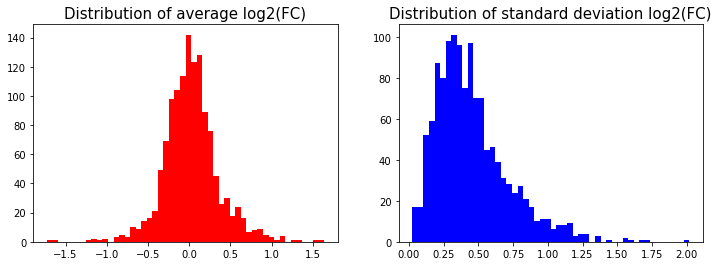

In [553]:
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(P67L_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(P67L_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

           params     sigma
mu1     -3.229044  1.255343
sigma1   1.474743  1.038401
A1       1.014320  0.314104
mu2      0.045505  0.041520
sigma2   1.107862  0.031249
A2      23.649953  0.523071


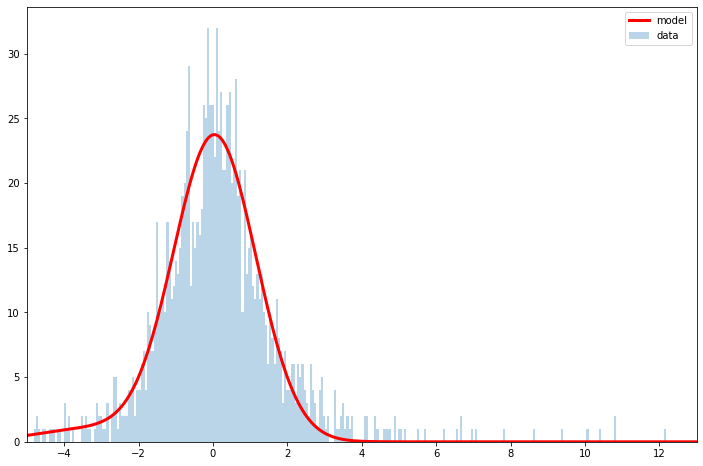

In [557]:
data=P67L_DMSO_over_TD_2plot['sum']
plt.figure(figsize=(12,8))
y,x,_=hist(data,500,alpha=.3,label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#expected=(-2.0,.46,84, #for sum data
     #     1.3,.2,84)
    
expected=(-0.88,.2,42, # for avg data
          0.0,.43,76)  

params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.xlim(-5,13)
legend()

P67L_parameters = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:]) 
print(P67L_parameters)

P67L_DMSO_over_TD_2plot['pvals'] = calc_pvals(data, P67L_parameters)

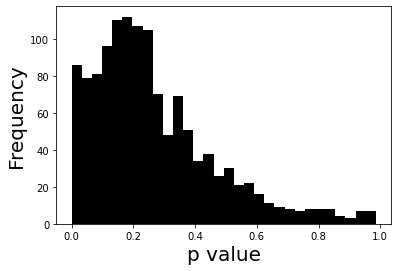

In [558]:
## plot a histogram of the p values 
plt.hist(P67L_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()

In [312]:
# calculat the log 10 FDR 

# rank order the p values 
P67L_DMSO_over_TD_2plot = P67L_DMSO_over_TD_2plot.sort_values('pvals')

#calculate pi i 
lamda = 0.4
N = len(P67L_DMSO_over_TD_2plot )
for i,val in enumerate(P67L_DMSO_over_TD_2plot['pvals']):
    if val >= (lamda - 0.05):
        cutoff = i+1
        break
        
pi0 = (N-cutoff)/(N-(1-lamda))
P67L_DMSO_over_TD_2plot['-log10(qvals)'] = -np.log10(qval(P67L_DMSO_over_TD_2plot['pvals'],pi0))

Text(0, 0.5, '-log10(FDR)')

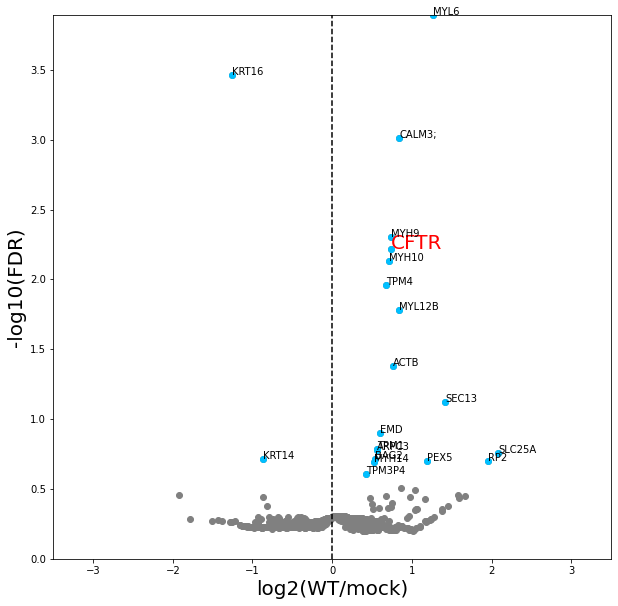

In [316]:
x = P67L_DMSO_over_TD_2plot['avg']
#y = -np.log10(P67L_DMSO_over_TD_2plot['pvals'])
y = P67L_DMSO_over_TD_2plot['-log10(qvals)']

x = x.replace(np.inf, np.nan)
y = y.replace(np.inf, np.nan)

cutoff = -np.log10(0.25)
rng = 3.5
fontsize = 20
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'grey')

plt.vlines((0), 0, max(y), ls='--' , color = 'k')

#plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))
'''
#plot medium confidence cut off curve
x_std = np.std(x)
x_rng = np.arange(x_std, rng, 0.01)
y_rng = c/(x_rng-x_std)
plt.plot(x_rng,y_rng, color='deepskyblue',ls='--' )
'''
#for i,val in enumerate(x):
 #   plt.text(x[i],y[i], str(data2.iloc[i]['Gene Name'])[:6], size=fontsize-10)
    
for i in x.items(): 
    if  y[i[0]] >= cutoff: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std:
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue')
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize, color ='r')
        else: 
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-10)


plt.xlabel('log2(WT/mock)', size=fontsize)
plt.ylabel('-log10(FDR)', size=fontsize)

# P67L + VX-809 Analysis

In [343]:
P67L_CFTR_VX809 = np.log2(data2[P67L_VX809])

In [344]:
P67L_CFTR_VX809 = P67L_CFTR_VX809.drop(columns = ['Run 8 P67L-VX809-37C', 'Run 8 P67L-VX809-28C'])

In [345]:
len(P67L_CFTR_VX809) 

3323

In [346]:
P67L_VX809_mocks = get_mock_runs(P67L_CFTR_VX809, TD_tom,0)
P67L_VX809_over_TD = pd.DataFrame(P67L_CFTR_VX809.values - P67L_VX809_mocks.values)

In [339]:
P67L_stat_vals_VX809 = stats.ttest_rel(P67L_CFTR_VX809.values,  P67L_VX809_mocks.values, axis=1, nan_policy= 'omit')

In [354]:
## filter out any proteins which were not identified in at least 3 runs 
P67L_VX809_over_TD_2plot = pd.DataFrame()
P67L_VX809_over_TD_2plot['nans'] =P67L_VX809_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(P67L_VX809_over_TD_2plot['nans']):
    if val >12:
        drop_rows.append(i)
        
P67L_VX809_over_TD = P67L_VX809_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(P67L_VX809_over_TD)))

the number of interactors left = 2839


In [361]:
P67L_VX809_over_TD_2plot = pd.DataFrame()
P67L_VX809_over_TD_2plot['avg'] = P67L_VX809_over_TD.mean(axis=1)
P67L_VX809_over_TD_2plot['med'] = P67L_VX809_over_TD.median(axis=1)
P67L_VX809_over_TD_2plot['std'] = P67L_VX809_over_TD.std(axis=1)
P67L_VX809_over_TD_2plot['sum'] = P67L_VX809_over_TD.sum(axis=1)
P67L_VX809_over_TD_2plot['sum'] = P67L_VX809_over_TD_2plot['sum'].replace(0.0, np.nan)
#P67L_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(P67L_stat_vals_VX809[1])
#P67L_VX809_over_TD_2plot['-log10 p_val'] = P67L_VX809_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of standard deviation log2(FC)')

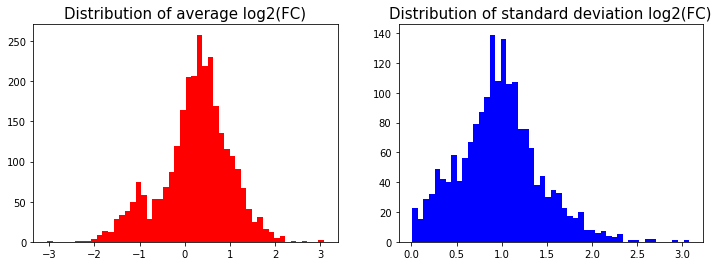

In [362]:
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(P67L_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(P67L_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

            params      sigma
mu1      -1.079297   0.034365
sigma1    0.363622   0.035865
A1      130.643304  10.219663
mu2       0.921547   0.033584
sigma2    0.937783   0.037488
A2      234.217972   6.140959


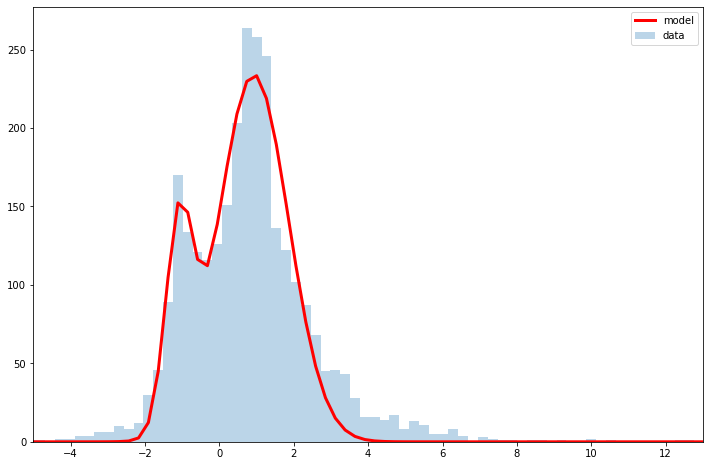

In [364]:
data=P67L_VX809_over_TD_2plot['sum']
plt.figure(figsize=(12,8))
y,x,_=hist(data,100,alpha=.3,label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-1.0,.48,40,
          .93,.84,62)

params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.xlim(-5,13)
legend()

P67L_parameters = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:]) 
print(P67L_parameters)

P67L_VX809_over_TD_2plot['pvals'] = calc_pvals(data, P67L_parameters)

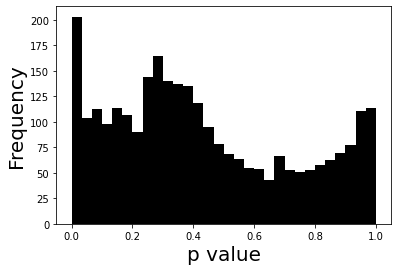

In [358]:
## plot a histogram of the p values 
plt.hist(P67L_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()

In [366]:
# calculat the log 10 FDR 

# rank order the p values 
P67L_VX809_over_TD_2plot = P67L_VX809_over_TD_2plot.sort_values('pvals')

#calculate pi i 
lamda = 0.4
N = len(P67L_VX809_over_TD_2plot )
for i,val in enumerate(P67L_VX809_over_TD_2plot['pvals']):
    if val >= (lamda - 0.05):
        cutoff = i+1
        break
        
pi0 = (N-cutoff)/(N-(1-lamda))
P67L_VX809_over_TD_2plot['-log10(qvals)'] = -np.log10(qval(P67L_VX809_over_TD_2plot['pvals'],pi0))

Text(0, 0.5, '-log10(FDR)')

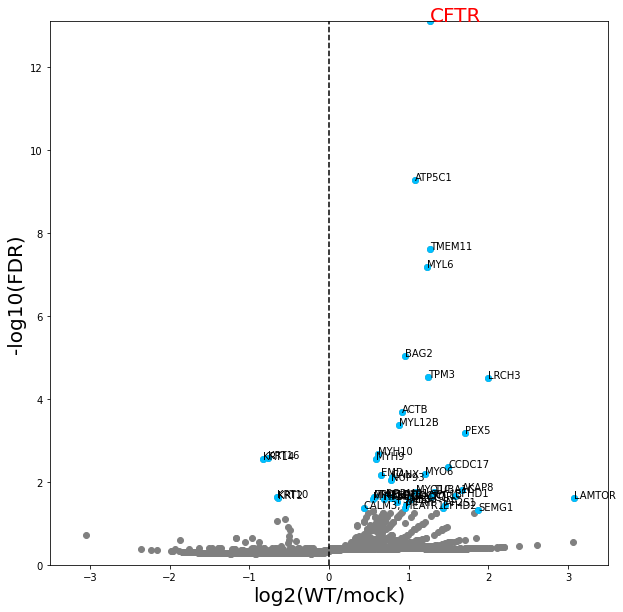

In [368]:
x = P67L_VX809_over_TD_2plot['avg']
#y = -np.log10(P67L_VX809_over_TD_2plot['pvals'])
y = P67L_VX809_over_TD_2plot['-log10(qvals)']

x = x.replace(np.inf, np.nan)
y = y.replace(np.inf, np.nan)

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 20
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'grey')

plt.vlines((0), 0, max(y), ls='--' , color = 'k')

#plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))
'''
#plot medium confidence cut off curve
x_std = np.std(x)
x_rng = np.arange(x_std, rng, 0.01)
y_rng = c/(x_rng-x_std)
plt.plot(x_rng,y_rng, color='deepskyblue',ls='--' )
'''
#for i,val in enumerate(x):
 #   plt.text(x[i],y[i], str(data2.iloc[i]['Gene Name'])[:6], size=fontsize-10)
    
for i in x.items(): 
    if  y[i[0]] >= cutoff: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std:
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue')
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize, color ='r')
        else: 
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-10)


plt.xlabel('log2(WT/mock)', size=fontsize)
plt.ylabel('-log10(FDR)', size=fontsize)

### L206W Abundance Analysis

In [193]:
L206W_CFTR_DMSO = np.log2(data2[L206W_DMSO])

In [194]:
L206W_CFTR_VX809 = np.log2(data2[L206W_VX809])

In [195]:
L206W_DMSO_mocks = get_mock_runs(L206W_CFTR_DMSO, TD_tom,0)
L206W_DMSO_over_TD = pd.DataFrame(L206W_CFTR_DMSO.values - L206W_DMSO_mocks.values)

In [196]:
L206W_VX809_mocks = get_mock_runs(L206W_CFTR_VX809, TD_tom,0)
L206W_VX809_over_TD = pd.DataFrame(L206W_CFTR_VX809.values - L206W_VX809_mocks.values)

In [197]:
L206W_stat_vals_DMSO = stats.ttest_rel(L206W_CFTR_DMSO.values, L206W_DMSO_mocks.values, axis=1, nan_policy= 'omit')
L206W_stat_vals_VX809 = stats.ttest_rel(L206W_CFTR_VX809.values,  L206W_VX809_mocks.values, axis=1, nan_policy= 'omit')

In [198]:
L206W_DMSO_over_TD_2plot = pd.DataFrame()
L206W_DMSO_over_TD_2plot['avg'] = L206W_DMSO_over_TD.mean(axis=1)
L206W_DMSO_over_TD_2plot['med'] = L206W_DMSO_over_TD.median(axis=1)
L206W_DMSO_over_TD_2plot['sum'] = L206W_DMSO_over_TD.sum(axis=1)
L206W_DMSO_over_TD_2plot['sum'] = L206W_DMSO_over_TD_2plot['sum'].replace(0.0, np.nan)
L206W_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(L206W_stat_vals_DMSO[1])
L206W_DMSO_over_TD_2plot['-log10 p_val'] = L206W_DMSO_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

            params     sigma
mu1      -2.094291  0.017520
sigma1    0.756893  0.017857
A1       98.631958  1.976822
mu2       0.719506  0.012941
sigma2    0.468984  0.013076
A2      105.477639  2.502242


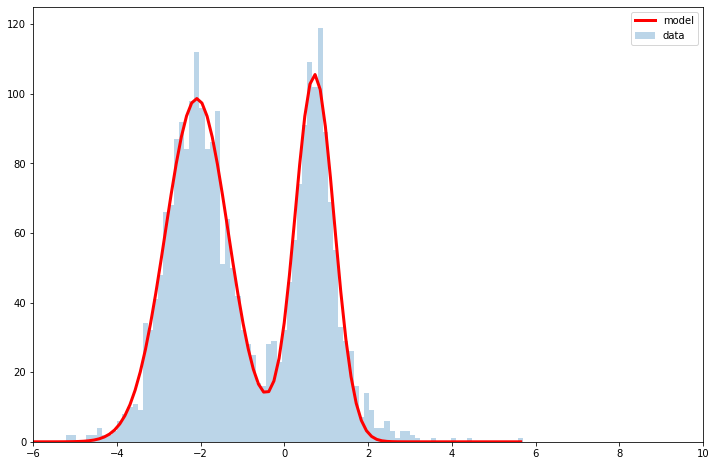

In [199]:
data=L206W_DMSO_over_TD_2plot['sum']
plt.figure(figsize=(12,8))
y,x,_=hist(data,100,alpha=.3,label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-2,.8,100,
          .7,.5,100)

params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.xlim(-6,10)
legend()

L206W_parameters = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:]) 
print(L206W_parameters)

L206W_DMSO_over_TD_2plot['pvals'] = calc_pvals(data, L206W_parameters)

/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


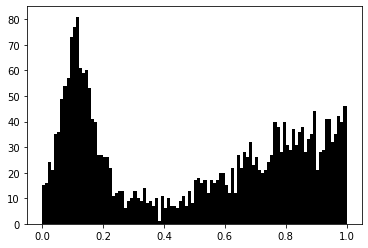

In [200]:
plt.hist(L206W_DMSO_over_TD_2plot['pvals'], bins=100, color='k')
plt.show()

In [187]:
L206W_VX809_over_TD_2plot = pd.DataFrame()
L206W_VX809_over_TD_2plot['avg'] = L206W_VX809_over_TD.mean(axis=1)
L206W_VX809_over_TD_2plot['med'] = L206W_VX809_over_TD.median(axis=1)
L206W_VX809_over_TD_2plot['sum'] = L206W_VX809_over_TD.sum(axis=1)
L206W_VX809_over_TD_2plot['sum'] = L206W_VX809_over_TD_2plot['sum'].replace(0.0, np.nan)
L206W_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(L206W_stat_vals_VX809[1])
L206W_VX809_over_TD_2plot['-log10 p_val'] = L206W_VX809_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


           params     sigma
mu1     -1.322360  0.025802
sigma1   0.869101  0.028503
A1      90.979769  2.188990
mu2      0.974752  0.023105
sigma2   0.436802  0.023351
A2      72.726723  3.015728


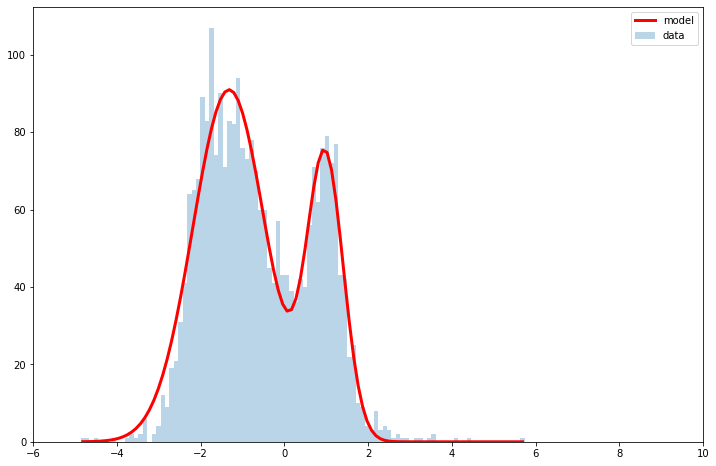

In [193]:
data=L206W_VX809_over_TD_2plot['sum']
plt.figure(figsize=(12,8))
y,x,_=hist(data,100,alpha=.3,label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-2,.8,100,
          .7,.5,100)

params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.xlim(-6,10)
legend()

L206W_parameters = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:]) 
print(L206W_parameters)
L206W_VX809_over_TD_2plot['pvals'] = calc_pvals(data, L206W_parameters)

Text(0, 0.5, 'Log10(p value)')

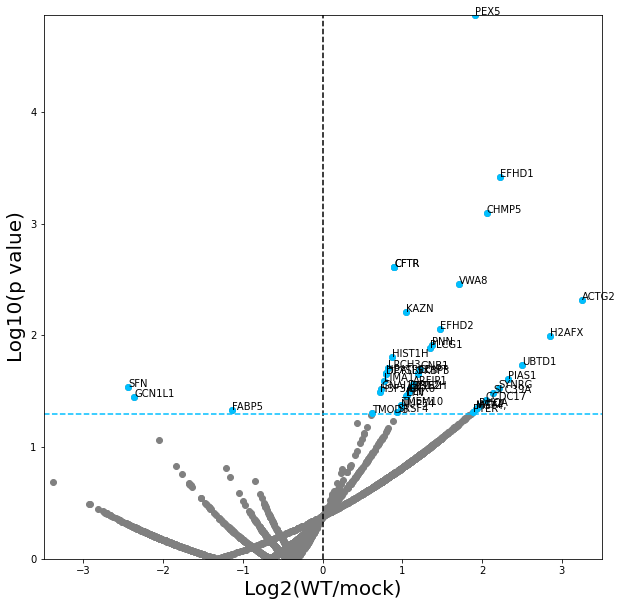

In [241]:
x = L206W_VX809_over_TD_2plot['avg']

y = -np.log10(L206W_VX809_over_TD_2plot['pvals']) 
y = y.replace(np.inf, np.nan)


cutoff = -np.log10(0.05)

rng = 3.5
fontsize = 20
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'grey')
plt.vlines((0), 0, max(y), ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))

#plot medium confidence cut off curve
#x_std = np.std(x)
#x_rng = np.arange(x_std, rng, 0.01)
#y_rng = c/(x_rng-x_std)
#plt.plot(x_rng,y_rng, color='deepskyblue',ls='--' )


for i,val in enumerate(y): 
    if val >= cutoff:
        plt.scatter(x[i], y[i], color = 'deepskyblue')
        plt.text(x[i],y[i], str(data2.iloc[i]['Gene Name'])[:6], size=fontsize-10)
        #print(str(data2.iloc[i]['Gene Name'])[:6])
#for i,val in enumerate(x): 
 #   if y[i] >= c/(val-x_std) and val >= x_std:
  #      plt.scatter(val, y[i], color = 'deepskyblue')
   #     plt.text(val,y[i], str(data2.iloc[i]['Gene Name'])[:6], size=fontsize-10)
    #    print(str(data2.iloc[i]['Gene Name'])[:6])

plt.xlabel('Log2(WT/mock)', size=fontsize)
plt.ylabel('Log10(p value)', size=fontsize)



### G85E Abundance Analysis

In [353]:
G85E_CFTR_DMSO = np.log2(data2[G85E_DMSO])

In [354]:
G85E_CFTR_VX809 = np.log2(data2[G85E_VX809])

In [355]:
G85E_DMSO_mocks = get_mock_runs(G85E_CFTR_DMSO, TD_tom,0)
G85E_DMSO_over_TD = pd.DataFrame(G85E_CFTR_DMSO.values - G85E_DMSO_mocks.values)

In [356]:
G85E_VX809_mocks = get_mock_runs(G85E_CFTR_VX809, TD_tom,0)
G85E_VX809_over_TD = pd.DataFrame(G85E_CFTR_VX809.values - G85E_VX809_mocks.values)

In [357]:
G85E_stat_vals_DMSO = stats.ttest_rel(G85E_CFTR_DMSO.values, G85E_DMSO_mocks.values, axis=1, nan_policy= 'omit')
G85E_stat_vals_VX809 = stats.ttest_rel(G85E_CFTR_VX809.values, G85E_VX809_mocks.values, axis=1, nan_policy= 'omit')

In [358]:
G85E_DMSO_over_TD_2plot = pd.DataFrame()
G85E_DMSO_over_TD_2plot['avg'] = G85E_DMSO_over_TD.mean(axis=1)
G85E_DMSO_over_TD_2plot['med'] = G85E_DMSO_over_TD.median(axis=1)
G85E_DMSO_over_TD_2plot['sum'] = G85E_DMSO_over_TD.sum(axis=1)
G85E_DMSO_over_TD_2plot['sum'] = G85E_DMSO_over_TD_2plot['sum'].replace(0.0, np.nan)
G85E_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(G85E_stat_vals_DMSO[1])
G85E_DMSO_over_TD_2plot['-log10 p_val'] = G85E_DMSO_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

In [359]:
G85E_VX809_over_TD_2plot = pd.DataFrame()
G85E_VX809_over_TD_2plot['avg'] = G85E_VX809_over_TD.mean(axis=1)
G85E_VX809_over_TD_2plot['med'] = G85E_VX809_over_TD.median(axis=1)
G85E_VX809_over_TD_2plot['sum'] = G85E_VX809_over_TD.sum(axis=1)
G85E_VX809_over_TD_2plot['sum'] = G85E_VX809_over_TD_2plot['sum'].replace(0.0, np.nan)
G85E_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(G85E_stat_vals_VX809[1])
G85E_VX809_over_TD_2plot['-log10 p_val'] = G85E_VX809_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


           params     sigma
mu1     -1.785194  0.016350
sigma1   0.575995  0.017481
A1      98.274395  2.304446
mu2      0.308543  0.052508
sigma2   0.515622  0.055345
A2      29.103949  2.421453


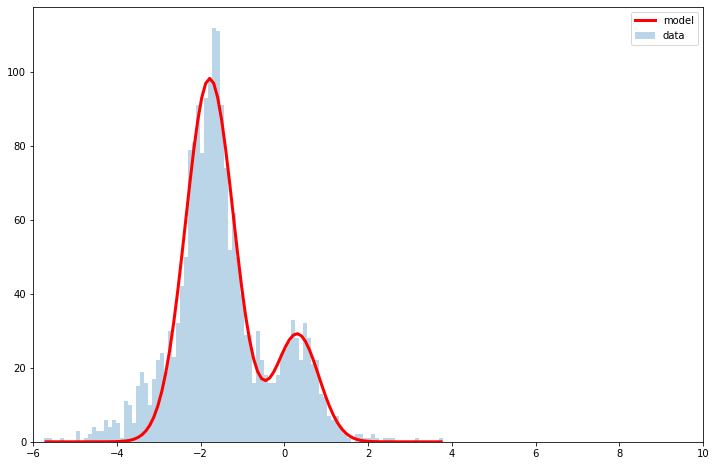

In [651]:
data=G85E_DMSO_over_TD_2plot['sum']
plt.figure(figsize=(12,8))
y,x,_=hist(data,100,alpha=.3,label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-1.8,.6,100,
          0.3,.5,30)

params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.xlim(-6,10)
legend()

G85E_parameters = pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:]) 
print(G85E_parameters)

In [652]:
data = G85E_DMSO_over_TD_2plot['sum']
params = G85E_parameters

rpec_std = np.std(data)
numerator = np.abs(data-params.loc['mu1']['params'])
denominator = np.sqrt(2* (rpec_std**2 + params.loc['sigma1']['params']**2 + params.loc['sigma2']['params']**2) )

G85E_pvals = special.erf(numerator/denominator)
G85E_pvals = G85E_pvals- 0.000001

In [656]:
G85E_DMSO_over_TD_2plot['avg']

0       0.404872
1      -0.497908
2      -1.771584
3            NaN
4      -1.118045
5            NaN
6      -0.967882
7      -0.857049
8      -1.103131
9      -1.023027
10      1.789321
11           NaN
12     -2.225232
13     -1.859634
14     -4.906032
15      0.368243
16           NaN
17     -0.283285
18      0.632072
19      1.000000
20     -0.676713
21     -2.536053
22     -0.803441
23           NaN
24           NaN
25      0.285270
26     -0.305542
27     -2.139158
28           NaN
29           NaN
30           NaN
31           NaN
32     -0.780480
33           NaN
34     -0.114437
35     -0.341857
36     -1.172239
37           NaN
38     -1.813988
39     -0.971242
40     -1.248633
41      0.856975
42     -0.794223
43     -0.495559
44     -1.888969
45     -1.594947
46      0.355278
47     -0.596790
48     -1.703282
49     -1.885118
50           NaN
51     -1.838719
52           NaN
53     -0.911422
54     -0.594046
55     -1.751023
56     -2.136246
57           NaN
58           N

Text(0, 0.5, 'Log10(p value)')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


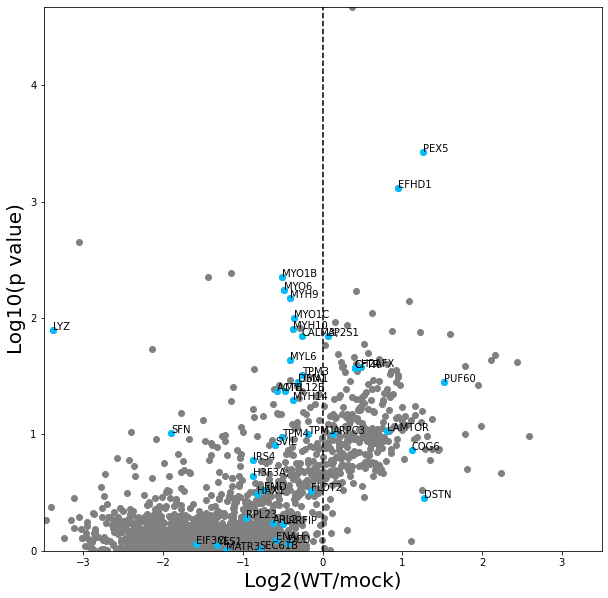

In [655]:
x = G85E_DMSO_over_TD_2plot['avg']
#y = G85E_DMSO_over_TD['-log10 p_val']

y = -np.log10(1-L206W_pvals) 
y = y.replace(np.inf, np.nan)

c = 0.4
rng = 3.5
fontsize = 20
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'grey')
plt.vlines((0), 0, max(y), ls='--' , color = 'k')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))

#plot medium confidence cut off curve
#x_std = np.std(x)
#x_rng = np.arange(x_std, rng, 0.01)
#y_rng = c/(x_rng-x_std)
#plt.plot(x_rng,y_rng, color='deepskyblue',ls='--' )

for i,val in enumerate(pvals): 
    if val >= 0.95 :
        plt.scatter(x[i], y[i], color = 'deepskyblue')
        plt.text(x[i],y[i], str(data2.iloc[i]['Gene Name'])[:6], size=fontsize-10)

#for i,val in enumerate(x): 
 #   if y[i] >= c/(val-x_std) and val >= x_std:
  #      plt.scatter(val, y[i], color = 'deepskyblue')
   #     plt.text(val,y[i], str(data2.iloc[i]['Gene Name'])[:6], size=fontsize-10)
    #    print(str(data2.iloc[i]['Gene Name'])[:6])

plt.xlabel('Log2(WT/mock)', size=fontsize)
plt.ylabel('Log10(p value)', size=fontsize)